In [1]:
import sys, os, pickle
import pandas as pd
import numpy as np

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt

from create_datasets import create_nx_datasets
from create_datasets.create_table_datasets import adni_data
from ml_models.machine_learning_models import create_class_ADNI, baseline_model
from ml_models.utils import boxplot_comparison_models, statistics, barplot_comparison_models

**1. Create table datasets**

Create table datasets (with and without APOE) for the targets and genes of interest to use as input for non-GNN models.

In [2]:
# Input: type of variant, best network from previous analysis, missense data, diagnosis/metadata
table_dataset = adni_data('missense',
                          'data/other_networks/AD_SNAP_PPI_brain.edgelist',
                          'data/ADNI/AD_PPI_missense.csv',
                          'data/ADNI/ADNIMERGE_metadata.csv')
table_dataset.to_csv(f'data/table_datasets/AD_PPI_missense_ADNI_labeled.csv')

**2. Baseline models - Logistic Regression only with APOE**

In [5]:
targets = ['PET', 'PETandDX']

for target in targets:
    
    result_df = pd.DataFrame(columns = ['fold', 'target', 'dataset', 'model', 'acc', 'pre', 'rec', 'f1', 'auc'])

    data = pd.read_csv('data/table_datasets/AD_PPI_missense_ADNI_labeled.csv', index_col = 0)
    data_wclass = create_class_ADNI(data, target)

    x = data_wclass.drop(columns=['y'])
    x = x['APOE']

    y = data_wclass['y']
    x.index = x.index.str.upper()

    for i in range(10):

        i += 1

        f = open(f'data/splits/10Fold_CV_{target}/k{i}_{target}.pkl', 'rb')
        split = pickle.load(f)
        f.close()

        tr_idx = split['train']
        te_idx = split['valid']

        x_train, x_test = x.iloc[tr_idx], x.iloc[te_idx]
        y_train, y_test = y[tr_idx], y[te_idx]

        x_train = np.array(x_train).reshape(-1, 1)
        x_test = np.array(x_test).reshape(-1, 1)

        scaler = preprocessing.StandardScaler().fit(x_train)
        x_train_scaled = scaler.transform(x_train)
        x_test_scaled = scaler.transform(x_test)

        logreg = LogisticRegression()
        logreg.fit(x_train_scaled, y_train)

        y_prob = logreg.predict_proba(x_test_scaled)

        y_pred = logreg.predict(x_test_scaled)
        acc = metrics.accuracy_score(y_test, y_pred)
        pre = metrics.precision_score(y_test, y_pred)
        rec = metrics.recall_score(y_test, y_pred)
        f1  = metrics.f1_score(y_test, y_pred)
        auc = metrics.roc_auc_score(y_test, y_prob[:, 1])

        result_df.loc[len(result_df)] = [i, target, 'Only APOE', 'Baseline model', acc, pre, rec, f1, auc]

    result_df.to_csv(f'results/2022_03_baseline_models_{target}.csv', index=False)

**3. Other non-GNN models: Logistic Regression, SVM Linear, SVM RBF, Random Forest**

In [4]:
for target in ['PET', 'PETandDX']:
    
    print(target)
        
    data = pd.read_csv('data/table_datasets/AD_PPI_missense_ADNI_labeled.csv', index_col = 0)
    data_wclass = create_class_ADNI(data, target) # label dataset with the corresponding label
    data_wclass = data_wclass.loc[:, (data_wclass != 0).any(axis=0)] # delete genes that do not have mutations (all zeroes)
    
    x = data_wclass.drop(columns=['y'])
    y = data_wclass['y']
    x.index = x.index.str.upper()
    
    results = [] # list of lists that stores performance metrics
    
    for i in range(10):

        i += 1
        
        print('Fold', i)
        print('-------------------------------------------------')

        f = open(f'data/splits/10Fold_CV_{target}/k{i}_{target}.pkl', 'rb')
        split = pickle.load(f)
        f.close()

        tr_idx = split['train']
        te_idx = split['valid']

        x_train, x_test = x.iloc[tr_idx], x.iloc[te_idx]
        y_train, y_test = y[tr_idx], y[te_idx]

        scaler = preprocessing.StandardScaler().fit(x_train)
        x_train_scaled = scaler.transform(x_train)
        x_test_scaled = scaler.transform(x_test)

        # Logistic Regression
        logreg = LogisticRegression()
        logreg.fit(x_train_scaled, y_train)
        y_prob_logreg = logreg.predict_proba(x_test_scaled)
        y_pred_logreg = logreg.predict(x_test_scaled)
        results.append([i, target, 'AD PPT-Ohmnet', 'Logistic Regression',
                        metrics.accuracy_score(y_test, y_pred_logreg),
                        metrics.precision_score(y_test, y_pred_logreg),
                        metrics.recall_score(y_test, y_pred_logreg),
                        metrics.f1_score(y_test, y_pred_logreg),
                        metrics.roc_auc_score(y_test, y_prob_logreg[:, 1])])

        # SVM Linear
        svm_lin = SVC(probability=True)
        param_grid_svm_lin = [{'C': [0.01, 0.1, 1, 10, 100, 1000]}]
        grid_search_svm_lin = GridSearchCV(svm_lin, param_grid_svm_lin, cv=10, scoring='roc_auc', n_jobs = -1, verbose = 3)
        grid_search_svm_lin.fit(x_train_scaled, y_train)
        print(grid_search_svm_lin.best_estimator_)
        y_prob_svm_lin = grid_search_svm_lin.predict_proba(x_test_scaled)
        y_pred_svm_lin = grid_search_svm_lin.predict(x_test_scaled)
        results.append([i, target, 'AD PPT-Ohmnet', 'SVM Linear',
                        metrics.accuracy_score(y_test, y_pred_svm_lin),
                        metrics.precision_score(y_test, y_pred_svm_lin),
                        metrics.recall_score(y_test, y_pred_svm_lin),
                        metrics.f1_score(y_test, y_pred_svm_lin),
                        metrics.roc_auc_score(y_test, y_prob_svm_lin[:, 1])])

        # SVM RBF
        svm_rbf = SVC(probability=True, kernel='rbf')
        param_grid_svm_rbf = [{'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1]}]
        grid_search_svm_rbf = GridSearchCV(svm_rbf, param_grid_svm_rbf, cv=10, scoring='roc_auc', n_jobs = -1, verbose = 3)
        grid_search_svm_rbf.fit(x_train_scaled, y_train)
        print(grid_search_svm_rbf.best_estimator_)
        y_prob_svm_rbf = grid_search_svm_rbf.predict_proba(x_test_scaled)
        y_pred_svm_rbf = grid_search_svm_rbf.predict(x_test_scaled)
        results.append([i, target, 'AD PPT-Ohmnet', 'SVM RBF',
                        metrics.accuracy_score(y_test, y_pred_svm_rbf),
                        metrics.precision_score(y_test, y_pred_svm_rbf),
                        metrics.recall_score(y_test, y_pred_svm_rbf),
                        metrics.f1_score(y_test, y_pred_svm_rbf),
                        metrics.roc_auc_score(y_test, y_prob_svm_rbf[:, 1])])

        # Random Forest
        rf_clf = RandomForestClassifier()
        param_grid = [{'n_estimators': [50, 500, 5000]}]
        grid_search_rf = GridSearchCV(rf_clf, param_grid, cv=10, scoring='roc_auc', n_jobs = -1, verbose = 3)
        grid_search_rf.fit(x_train, y_train)
        print(grid_search_rf.best_estimator_)
        y_prob_rf = grid_search_rf.predict_proba(x_test)
        y_pred_rf = grid_search_rf.predict(x_test)
        results.append([i, target, 'AD PPT-Ohmnet', 'Random Forest',
                        metrics.accuracy_score(y_test, y_pred_rf),
                        metrics.precision_score(y_test, y_pred_rf),
                        metrics.recall_score(y_test, y_pred_rf),
                        metrics.f1_score(y_test, y_pred_rf),
                        metrics.roc_auc_score(y_test, y_prob_rf[:, 1])])

        print()
        
    results_df = pd.DataFrame(results, columns=['fold', 'target', 'dataset', 'model', 'acc', 'pre', 'rec', 'f1', 'auc'])
    results_df.to_csv(f'results/2022_03_nonGNN_models_{target}.csv', index=False)


PET
Fold 1
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=0.01, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits
SVC(C=0.01, gamma=1, probability=True)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
RandomForestClassifier(n_estimators=5000)

Fold 2
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=10, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits
SVC(C=0.01, gamma=1, probability=True)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
RandomForestClassifier(n_estimators=50)

Fold 3
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=1000, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits
SVC(C=10, gamma=0.1, probability=True)
Fitting 10 folds for each of 3 candidates,

**4. Other non-GNN models: Logistic Regression, SVM Linear, SVM RBF, Random Forest WITHOUT APOE**

In [6]:
for target in ['PET', 'PETandDX']:
    
    print(target)
        
    data = pd.read_csv('data/table_datasets/AD_PPI_missense_ADNI_labeled.csv', index_col = 0)
    data_wclass = create_class_ADNI(data, target) # label dataset with the corresponding label
    data_wclass = data_wclass.loc[:, (data_wclass != 0).any(axis=0)] # delete genes that do not have mutations (all zeroes)
    
    x = data_wclass.drop(columns=['y', 'APOE']) # DELETE APOE GENE !!
    y = data_wclass['y']
    x.index = x.index.str.upper()
    
    results = [] # list of lists that stores performance metrics
    
    for i in range(10):

        i += 1
        
        print('Fold', i)
        print('-------------------------------------------------')

        f = open(f'data/splits/10Fold_CV_{target}/k{i}_{target}.pkl', 'rb')
        split = pickle.load(f)
        f.close()

        tr_idx = split['train']
        te_idx = split['valid']

        x_train, x_test = x.iloc[tr_idx], x.iloc[te_idx]
        y_train, y_test = y[tr_idx], y[te_idx]

        scaler = preprocessing.StandardScaler().fit(x_train)
        x_train_scaled = scaler.transform(x_train)
        x_test_scaled = scaler.transform(x_test)

        # Logistic Regression
        logreg = LogisticRegression()
        logreg.fit(x_train_scaled, y_train)
        y_prob_logreg = logreg.predict_proba(x_test_scaled)
        y_pred_logreg = logreg.predict(x_test_scaled)
        results.append([i, target, 'AD PPT-Ohmnet no APOE', 'Logistic Regression',
                        metrics.accuracy_score(y_test, y_pred_logreg),
                        metrics.precision_score(y_test, y_pred_logreg),
                        metrics.recall_score(y_test, y_pred_logreg),
                        metrics.f1_score(y_test, y_pred_logreg),
                        metrics.roc_auc_score(y_test, y_prob_logreg[:, 1])])

        # SVM Linear
        svm_lin = SVC(probability=True)
        param_grid_svm_lin = [{'C': [0.01, 0.1, 1, 10, 100, 1000]}]
        grid_search_svm_lin = GridSearchCV(svm_lin, param_grid_svm_lin, cv=10, scoring='roc_auc', n_jobs = -1, verbose = 3)
        grid_search_svm_lin.fit(x_train_scaled, y_train)
        print(grid_search_svm_lin.best_estimator_)
        y_prob_svm_lin = grid_search_svm_lin.predict_proba(x_test_scaled)
        y_pred_svm_lin = grid_search_svm_lin.predict(x_test_scaled)
        results.append([i, target, 'AD PPT-Ohmnet no APOE', 'SVM Linear',
                        metrics.accuracy_score(y_test, y_pred_svm_lin),
                        metrics.precision_score(y_test, y_pred_svm_lin),
                        metrics.recall_score(y_test, y_pred_svm_lin),
                        metrics.f1_score(y_test, y_pred_svm_lin),
                        metrics.roc_auc_score(y_test, y_prob_svm_lin[:, 1])])

        # SVM RBF
        svm_rbf = SVC(probability=True, kernel='rbf')
        param_grid_svm_rbf = [{'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1]}]
        grid_search_svm_rbf = GridSearchCV(svm_rbf, param_grid_svm_rbf, cv=10, scoring='roc_auc', n_jobs = -1, verbose = 3)
        grid_search_svm_rbf.fit(x_train_scaled, y_train)
        print(grid_search_svm_rbf.best_estimator_)
        y_prob_svm_rbf = grid_search_svm_rbf.predict_proba(x_test_scaled)
        y_pred_svm_rbf = grid_search_svm_rbf.predict(x_test_scaled)
        results.append([i, target, 'AD PPT-Ohmnet no APOE', 'SVM RBF',
                        metrics.accuracy_score(y_test, y_pred_svm_rbf),
                        metrics.precision_score(y_test, y_pred_svm_rbf),
                        metrics.recall_score(y_test, y_pred_svm_rbf),
                        metrics.f1_score(y_test, y_pred_svm_rbf),
                        metrics.roc_auc_score(y_test, y_prob_svm_rbf[:, 1])])

        # Random Forest
        rf_clf = RandomForestClassifier()
        param_grid = [{'n_estimators': [50, 500, 5000]}]
        grid_search_rf = GridSearchCV(rf_clf, param_grid, cv=10, scoring='roc_auc', n_jobs = -1, verbose = 3)
        grid_search_rf.fit(x_train, y_train)
        print(grid_search_rf.best_estimator_)
        y_prob_rf = grid_search_rf.predict_proba(x_test)
        y_pred_rf = grid_search_rf.predict(x_test)
        results.append([i, target, 'AD PPT-Ohmnet no APOE', 'Random Forest',
                        metrics.accuracy_score(y_test, y_pred_rf),
                        metrics.precision_score(y_test, y_pred_rf),
                        metrics.recall_score(y_test, y_pred_rf),
                        metrics.f1_score(y_test, y_pred_rf),
                        metrics.roc_auc_score(y_test, y_prob_rf[:, 1])])

        print()
        
    results_df = pd.DataFrame(results, columns=['fold', 'target', 'dataset', 'model', 'acc', 'pre', 'rec', 'f1', 'auc'])
    results_df.to_csv(f'results/2022_03_nonGNN_models_{target}_noAPOE.csv', index=False)


PET
Fold 1
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=0.01, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits
SVC(C=0.01, gamma=0.1, probability=True)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
RandomForestClassifier(n_estimators=500)

Fold 2
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=0.1, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits
SVC(C=0.01, gamma=0.001, probability=True)
Fitting 10 folds for each of 3 candidates, totalling 30 fits
RandomForestClassifier(n_estimators=50)

Fold 3
-------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits
SVC(C=1, probability=True)
Fitting 10 folds for each of 24 candidates, totalling 240 fits
SVC(C=1, gamma=0.1, probability=True)
Fitting 10 folds for each of 3 candidate

**5. Create graph datasets WITHOUT APOE**

Create the correspoding graph-datasets for each target without APOE gene.

We then evaluated and tested the best GNNs obtained for each target in the previous step.

Configuration and grid files employed are in the subdirectory graphgym_files.

We run GraphGym 10 times, with 10 different splits generated by 10-Fold Stratified Cross-Validation.

In [2]:
dataset = 'ADNI'
targets = ['PET', 'PETandDX']
network = 'snap_brain_noAPOE'

for target in targets:
    outdir = f'data/graph_datasets/{target}'

    result_nodes = create_nx_datasets.main('data', dataset, target, 'AD', network, 'missense', None)
    outfile = f'{outdir}/AD_PPI_{network}_missense.pkl'
    print('Resulting dataset saved at:', outfile)
    print()

    with open(outfile, 'wb') as f:
        pickle.dump(result_nodes, f)

Network used: AD snap_brain_noAPOE
# nodes = 28
# edges = 46

Dataset used: ADNI
missense
(28, 808)
Creating samples graphs...
Class: PET. Found 410 positive subjects out of 726
Sample graph used: # nodes = 28 # edges = 46
Density = 0.12169312169312169 Diameter = 6
Resulting dataset saved at: data/graph_datasets/PET/AD_PPI_snap_brain_noAPOE_missense.pkl

Network used: AD snap_brain_noAPOE
# nodes = 28
# edges = 46

Dataset used: ADNI
missense
(28, 808)
Creating samples graphs...
Class: PETandDX. Found 182 positive subjects out of 317
Sample graph used: # nodes = 28 # edges = 46
Density = 0.12169312169312169 Diameter = 6
Resulting dataset saved at: data/graph_datasets/PETandDX/AD_PPI_snap_brain_noAPOE_missense.pkl



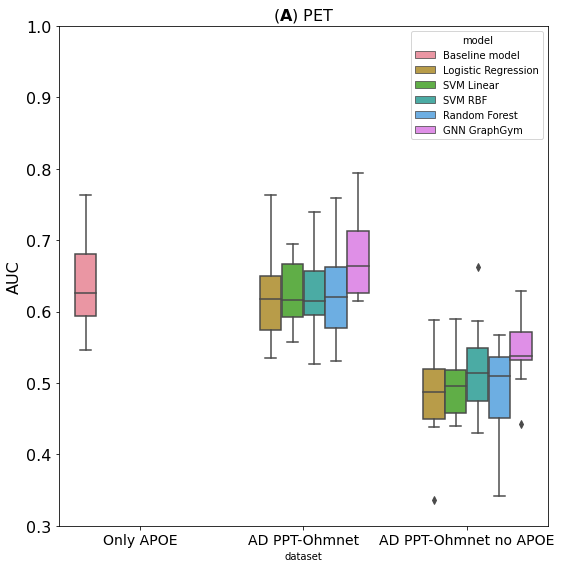

In [2]:
pet_nonGNN        = pd.read_csv('results/2022_03_nonGNN_models_PET.csv', index_col='fold')
pet_nonGNN_noAPOE = pd.read_csv('results/2022_03_nonGNN_models_PET_noAPOE.csv', index_col='fold')
pet_GNN           = pd.read_csv('results/2022_03_networks_PET.csv', index_col='fold')
pet_GNN_noAPOE    = pd.read_csv('results/2022_03_networks_PET_noAPOE.csv', index_col='fold')
pet_bas           = pd.read_csv('results/2022_03_baseline_models_PET.csv',  index_col='fold')

pet_all = pd.concat([pet_nonGNN, pet_nonGNN_noAPOE, pet_GNN, pet_GNN_noAPOE, pet_bas])
pet_all = pet_all.loc[
    (pet_all['dataset'] == 'Only APOE') |
    (pet_all['dataset'] == 'AD PPT-Ohmnet') | 
    (pet_all['dataset'] == 'AD PPT-Ohmnet no APOE')]
boxplot_comparison_models('PET', pet_all, 'auc', r"($\bf{A}$) PET")

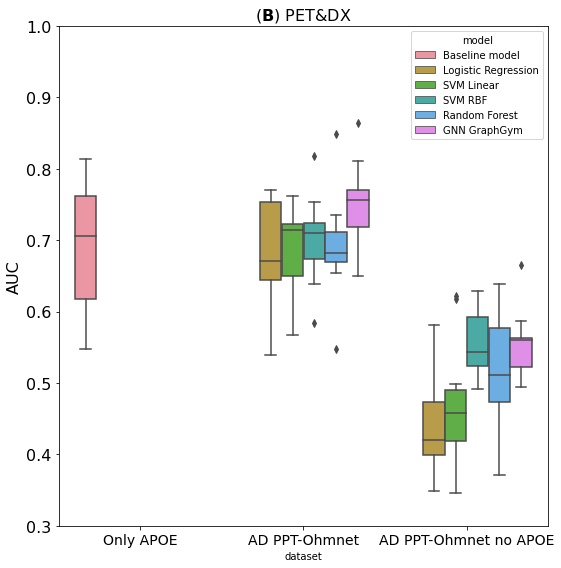

In [3]:
petdx_nonGNN        = pd.read_csv('results/2022_03_nonGNN_models_PETandDX.csv', index_col='fold')
petdx_nonGNN_noAPOE = pd.read_csv('results/2022_03_nonGNN_models_PETandDX_noAPOE.csv', index_col='fold')
petdx_GNN           = pd.read_csv('results/2022_03_networks_PETandDX.csv', index_col='fold')
petdx_GNN_noAPOE    = pd.read_csv('results/2022_03_networks_PETandDX_noAPOE.csv', index_col='fold')
petdx_bas           = pd.read_csv('results/2022_03_baseline_models_PETandDX.csv',  index_col='fold')

petdx_all = pd.concat([petdx_nonGNN, petdx_nonGNN_noAPOE, petdx_GNN, petdx_GNN_noAPOE, petdx_bas])
petdx_all = petdx_all.loc[
    (petdx_all['dataset'] == 'Only APOE') |
    (petdx_all['dataset'] == 'AD PPT-Ohmnet') | 
    (petdx_all['dataset'] == 'AD PPT-Ohmnet no APOE')]
boxplot_comparison_models('PETandDX', petdx_all, 'auc', r"($\bf{B}$) PET&DX")

In [4]:
pvalues_bas_pet, pvalues_ran_pet = statistics(pet_all)

Against baseline:
( ) 1.0072e-01 AD PPT-Ohmnet - GNN GraphGym
( ) 6.3489e-01 AD PPT-Ohmnet - Random Forest
( ) 6.6811e-01 AD PPT-Ohmnet - SVM RBF
( ) 6.8956e-01 AD PPT-Ohmnet - SVM Linear
( ) 7.1252e-01 AD PPT-Ohmnet - Logistic Regression
( ) 9.9871e-01 AD PPT-Ohmnet no APOE - GNN GraphGym
( ) 9.9939e-01 AD PPT-Ohmnet no APOE - SVM RBF
( ) 9.9992e-01 AD PPT-Ohmnet no APOE - Random Forest
( ) 9.9997e-01 AD PPT-Ohmnet no APOE - Logistic Regression
( ) 9.9999e-01 AD PPT-Ohmnet no APOE - SVM Linear

Against random:
(*) 2.8117e-08 AD PPT-Ohmnet - GNN GraphGym
(*) 9.4801e-08 AD PPT-Ohmnet - SVM Linear
(*) 2.4007e-06 AD PPT-Ohmnet - SVM RBF
(*) 1.2655e-05 AD PPT-Ohmnet - Logistic Regression
(*) 2.4519e-05 AD PPT-Ohmnet - Random Forest
(*) 5.9482e-03 AD PPT-Ohmnet no APOE - GNN GraphGym
( ) 2.0738e-01 AD PPT-Ohmnet no APOE - SVM RBF
( ) 6.5304e-01 AD PPT-Ohmnet no APOE - SVM Linear
( ) 7.2317e-01 AD PPT-Ohmnet no APOE - Random Forest
( ) 8.0911e-01 AD PPT-Ohmnet no APOE - Logistic Regression


In [5]:
pvalues_bas_petdx, pvalues_ran_petdx = statistics(petdx_all)

Against baseline:
( ) 5.1717e-02 AD PPT-Ohmnet - GNN GraphGym
( ) 3.7087e-01 AD PPT-Ohmnet - SVM RBF
( ) 4.9994e-01 AD PPT-Ohmnet - Random Forest
( ) 5.2998e-01 AD PPT-Ohmnet - SVM Linear
( ) 5.7567e-01 AD PPT-Ohmnet - Logistic Regression
( ) 9.9942e-01 AD PPT-Ohmnet no APOE - SVM RBF
( ) 9.9947e-01 AD PPT-Ohmnet no APOE - GNN GraphGym
( ) 9.9973e-01 AD PPT-Ohmnet no APOE - Random Forest
( ) 9.9997e-01 AD PPT-Ohmnet no APOE - SVM Linear
( ) 1.0000e+00 AD PPT-Ohmnet no APOE - Logistic Regression

Against random:
(*) 3.5879e-11 AD PPT-Ohmnet - GNN GraphGym
(*) 4.1907e-09 AD PPT-Ohmnet - SVM RBF
(*) 1.9995e-08 AD PPT-Ohmnet - SVM Linear
(*) 1.1994e-07 AD PPT-Ohmnet - Random Forest
(*) 2.5747e-07 AD PPT-Ohmnet - Logistic Regression
(*) 7.2958e-04 AD PPT-Ohmnet no APOE - SVM RBF
(*) 1.0028e-03 AD PPT-Ohmnet no APOE - GNN GraphGym
( ) 3.3975e-01 AD PPT-Ohmnet no APOE - Random Forest
( ) 8.5275e-01 AD PPT-Ohmnet no APOE - SVM Linear
( ) 9.8902e-01 AD PPT-Ohmnet no APOE - Logistic Regression
